In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
import os
import sys
import platform
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'glove50d:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F911310%2F1544853%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240907%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240907T170146Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D24743ef0d8c855b54c7ca73108048c6094cd8f39b8edf2a4663f0b50ddfe5e4a97bc672766ff2353fa1fe61a1274661744316ae8674ae4bbd9c5aaf49b00f558658f39c6223649cd8edaa2a90b53207063cc40167c86f66875116ffcc658615cd06f4d8459ccc993e2871e7995ada0b9a9a7fa5b90b8050c39ed043786df1e7777f52b323e74e27c1415853dab951200f712c6d9b8f771b3e7bb44b6c068ed32bf6ca0b11201995f1723c51ff1ffdf312c15b761bb04868171f85c36d0d13a955782a93741591faf59a98e682690a600934a54294b7e2dfd85e8dac9240ca0e9850ea6af80eacb76c52f35e4e83ae0324ed2ed836148da54137a41c350837fd7,fake-news-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1249857%2F2084561%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240907%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240907T170146Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D08fe71600e5dabff5bfaebb31f72e5bd4b7b03a9083390fc3b304dc7d90c70422b7440a46a4a0457b9ec725f0d749e2d3483a6f59093e61379227a28d9ebbe41af8f46d7497fa5dd9de172becdcff0b2611a0e53dc0d73eaa9f7382ae60468a7ac5d0b1208702b33b99cbc96ac0839fc32db638d4fd3ef2df44faf90e9a6cc8b5580430997e516fb0d50fbd5e6a2982226861168e9dc36938b6300383531481e15dfdd2ba7e8112fdabfd12a7bac9037d76a0708fd3a18485b286bce1e4c2bb2149026df4c970fb2eb7696909ae5edd9d2aa231ad68f189ea68475e52554ef9192eecfbd8fa196bda6385017c18ca685d7486ff0c42cd63ec9308a0c41bad439'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# Removing any pre-existing mount points
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Platform-specific handling for symbolic links
if platform.system() == 'Windows':
    print("Symbolic links are not supported without admin privileges on Windows. Skipping symlink creation.")
else:
    try:
        os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
    except FileExistsError:
        pass
    try:
        os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
    except FileExistsError:
        pass

# Download and extract data
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50 - done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
                
            # Extract the downloaded archive
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
                    
            print(f'\nDownloaded and uncompressed: {directory}')
    
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


Symbolic links are not supported without admin privileges on Windows. Skipping symlink creation.
[==================================================] 70948798 bytes downloaded
Downloaded and uncompressed: glove50d
[==================================================] 5340415 bytes downloaded
Downloaded and uncompressed: fake-news-challenge
Data source import complete.


# Problem Statement

1. We are given a dataset consisting of two csv files train_bodies.csv which contains the set of news articles bodies,while train-stances.csv resembles the articles for each of these bodies being identified using the body id.

2. After training from these samples we need to detect whether the given headline agrees,disagrees,discusses,unrelated with the body id


## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Activation, Reshape, Dense, GRU, Add, Flatten, concatenate, Bidirectional, Input

from tensorflow.keras.layers import LSTM, Embedding, Dropout, Activation, Reshape, Dense, GRU, Add, Flatten, concatenate, Bidirectional

from tensorflow.keras.callbacks import ModelCheckpoint


# Dataset understanding
The train_bodies contain the entries for the body id and associated article Body
The train_stances contain the entries for the headlines associated with the particular body id and its labelled stance
One body present in train_bodies can have multiple associated headlines present in train_stances and it's corresponding stance label
1683 :- Number of article Body present
49972 number of total headlines present for the 1683 different article body

## Dataset Preparation

**train_bodies.csv** contains body id and article body for training  
**train_stances.csv** contains headlines corresponding to body id and associated labelled stance with it


In [8]:
DATASET_PATH = "./fake/"

train_bodies = pd.read_csv(os.path.join(DATASET_PATH,'train_bodies.csv'))
# train_bodies.head()
train_stance = pd.read_csv(os.path.join(DATASET_PATH,'train_stances.csv'))

In [10]:
# !pip install tqdm

# Combining the CSV

I am preparing a final csv in each row will correspond to a unique entry
i.e each row will correspond to a unique combination of headline,bodyid and article body

The above is needed for making simplicity in further data preparation steps we need to execute


In [37]:
# !pip install tqdm
# !pip show tqdm
# !pip install tqdm




[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\k7adi\myenv\Scripts\python.exe -m pip install --upgrade pip


Name: tqdm
Version: 4.66.5
Summary: Fast, Extensible Progress Meter
Home-page: 
Author: 
Author-email: 
License: MPL-2.0 AND MIT
Location: c:\users\k7adi\myenv\lib\site-packages
Requires: colorama
Required-by: 


In [11]:
import sys
print(sys.executable)


g:\PROJECTS\MINI_PROJECT\Github\venv\Scripts\python.exe


In [12]:
import os
import pandas as pd

# Load the full DataFrames (replace with your actual loading code)
# train_stance = pd.read_csv('train_stance.csv')
# train_bodies = pd.read_csv('train_bodies.csv')

# Select 25% of the rows
train_stance_subset = train_stance.sample(frac=0.25, random_state=1).reset_index(drop=True)
train_bodies_subset = train_bodies.sample(frac=0.25, random_state=1).reset_index(drop=True)

# Initialize the 'articleBody' column in train_stance_subset
train_stance_subset['articleBody'] = None

# Merge process for the subset
for i in range(train_stance_subset.shape[0]):
    if i % 100 == 0:  # Print progress every 100 iterations
        print(f'Processing row {i}/{train_stance_subset.shape[0]}')
    for j in range(train_bodies_subset.shape[0]):
        if train_bodies_subset.loc[j, 'Body ID'] == train_stance_subset.loc[i, 'Body ID']:
            train_stance_subset.loc[i, 'articleBody'] = train_bodies_subset.loc[j, 'articleBody']

# Save the merged subset DataFrame to a new CSV file
train_stance_subset.to_csv(os.path.join(os.getcwd(), 'data_combined_subset.csv'), index=False)


Processing row 0/12493
Processing row 100/12493
Processing row 200/12493
Processing row 300/12493
Processing row 400/12493
Processing row 500/12493
Processing row 600/12493
Processing row 700/12493
Processing row 800/12493
Processing row 900/12493
Processing row 1000/12493
Processing row 1100/12493
Processing row 1200/12493
Processing row 1300/12493
Processing row 1400/12493
Processing row 1500/12493
Processing row 1600/12493
Processing row 1700/12493
Processing row 1800/12493
Processing row 1900/12493
Processing row 2000/12493
Processing row 2100/12493
Processing row 2200/12493
Processing row 2300/12493
Processing row 2400/12493
Processing row 2500/12493
Processing row 2600/12493
Processing row 2700/12493
Processing row 2800/12493
Processing row 2900/12493
Processing row 3000/12493
Processing row 3100/12493
Processing row 3200/12493
Processing row 3300/12493
Processing row 3400/12493
Processing row 3500/12493
Processing row 3600/12493
Processing row 3700/12493
Processing row 3800/1249

In [16]:
import pandas as pd
import os

# Load the combined data
data = pd.read_csv(os.path.join(os.getcwd(), 'data_combined_subset.csv'))

# Display the first few rows of the DataFrame
print(data.head())


                                            Headline  Body ID     Stance  \
0  Report: Amazon to Launch Ad-Supported Streamin...     1071  unrelated   
1  That Boko Haram Ceasefire in Nigeria Isn’t A C...       35  unrelated   
2  High School Student Rumored to Have Made $72 M...     1024  unrelated   
3  Al-Shabaab co-founder confirmed killed by US a...      646  unrelated   
4  Confusion swirls, details murky in arrest of I...     2337    discuss   

                                         articleBody  
0                                                NaN  
1                                                NaN  
2  A 10-year-old member of the ISIS terror group ...  
3  The mystery surrounding the disappearance of 4...  
4                                                NaN  


In [17]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()

Stance
unrelated    9079
discuss      2269
agree         923
disagree      222
Name: count, dtype: int64

In [18]:
import numpy as np
import pandas as pd

# Load the subset data
data = pd.read_csv(os.path.join(os.getcwd(), 'data_combined_subset.csv'))

# Fill missing values with an empty string
data['Headline'] = data['Headline'].fillna('')
data['articleBody'] = data['articleBody'].fillna('')

# Combine Headline and Article Body into one corpus
corpus = np.r_[data['Headline'].values, data['articleBody'].values]

# Print the expected length and actual length of the corpus
expected_length = 2 * len(data)  # Since we have two columns, Headline and articleBody
print(expected_length)
print(len(corpus))  # Actual length of the corpus

# Create a vocabulary list
vocabulary = []
for sentence in corpus:
    if isinstance(sentence, str):  # Check if the value is a string
        vocabulary.extend(sentence.split(' '))

# Remove duplicates and calculate vocabulary length
vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))


24986
24986
Vocabulary Length is 26719


## Model Training Parameters

In [19]:
# max_features = 5000
# MAX_NB_WORDS = 24000
# EMBEDDING_DIM = 50
# MAX_SEQUENCE_LENGTH = 64

max_features = 2000  # Reduced number of unique words
MAX_NB_WORDS = 5000  # Reduced vocabulary size
EMBEDDING_DIM = 50  # Typically remains the same
MAX_SEQUENCE_LENGTH = 50  # Adjust based on the average length of texts in the subset


## Creating Embedding Matrix For Headline and Body

We create Emebdding Matrix for headline and Body to be served as a first layer of Deep learning Model

In [21]:
GLOVE_DIR = "./fake/"
def setup_embedding_index():
    embedding_index=dict()
    f = open(os.path.join(GLOVE_DIR,"glove.6B.50d.txt"),encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
    f.close()
    return embedding_index
embeddings_index = setup_embedding_index()

## Padding headline and body

We pad the headline into length of 16 as headline is of shorter length and body into length of 48 as observed best performing parameter for body is 48.

In [22]:
tokenizer_headline = Tokenizer(num_words=max_features, split=' ')
tokenizer_headline.fit_on_texts(data.loc[:,'Headline'].values)
vocab_headline_length = len(tokenizer_headline.word_index)+1

encoded_docs_headline = tokenizer_headline.texts_to_sequences(data.loc[:,'Headline'])
padded_docs_headline = pad_sequences(encoded_docs_headline, maxlen=16, padding='post')

print(vocab_headline_length)
word_index_headline = tokenizer_headline.word_index

NUM_WORDS_HEADLINE = vocab_headline_length

3786


In [23]:
tokenizer_body = Tokenizer(num_words=max_features, split=' ')
tokenizer_body.fit_on_texts(data.loc[:,'articleBody'].values)
vocab_body_length = len(tokenizer_body.word_index)+1

encoded_docs_body = tokenizer_body.texts_to_sequences(data.loc[:,'articleBody'])
padded_docs_body = pad_sequences(encoded_docs_body, maxlen=48, padding='post')

print(vocab_body_length)
word_index_body = tokenizer_body.word_index

NUM_WORDS_BODY = vocab_body_length
print(NUM_WORDS_BODY)

13680
13680


In [24]:

embedding_matrix_headline = np.zeros((NUM_WORDS_HEADLINE, EMBEDDING_DIM))

for word, i in tokenizer_headline.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_headline[i] = embedding_vector
dims = len(embedding_matrix_headline[0])

print(dims)

50


In [25]:

embedding_matrix_body = np.zeros((NUM_WORDS_BODY, EMBEDDING_DIM))

for word, i in tokenizer_body.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_body[i] = embedding_vector
dims = len(embedding_matrix_body[0])

print(dims)

50


In [26]:
print(padded_docs_headline.shape)
print(padded_docs_body.shape)

(12493, 16)
(12493, 48)


## Model Architecture

In [45]:
input_headline = Input(shape=(16,), name='input_headline')
embedding_layer_headline = Embedding(input_dim = vocab_headline_length,output_dim = 50,
                                     weights=[embedding_matrix_headline],
                                     input_length = 16,trainable=True)(input_headline)

# lstm_headline = LSTM(units=16)(e+mbedding_layer_headline)

input_body = Input(shape=(48,), name='input_body')

embedding_layer_body = Embedding(input_dim = vocab_body_length,output_dim = 50,weights = [embedding_matrix_body],
                                 input_length=48,trainable = True)(input_body)
lstm_body = LSTM(units=48)(embedding_layer_body)

addition_layer = concatenate([embedding_layer_headline,embedding_layer_body],axis=1)

# addition_layer = concatenate([lstm_headline,lstm_body],axis=1)
lstm = LSTM(units=64,)(addition_layer)
drop = Dropout(0.25)(lstm)
# dense = Dense(64,activation='relu')(drop)
# flatten = Flatten()(addition_layer)

output = Dense(4,activation='sigmoid')(drop)

model = Model(inputs=[input_headline,input_body],outputs=output)
# from keras.optimizers import SGD
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss = "categorical_crossentropy", optimizer = sgd,metrics = ['accuracy'])

model.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])


In [46]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 16, 50)    │    189,300 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 48, 50)    │    684,000 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 50)    │          0 │ embedding_5[0][0… │
│ (Concatenate)       │                   │            │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     29,440 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 903,000 (3.44 MB)

 Trainable params: 903,000 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
!pip install pydot 
!pip install graphviz

You should consider upgrading via the 'G:\PROJECTS\MINI_PROJECT\Github\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'G:\PROJECTS\MINI_PROJECT\Github\venv\Scripts\python.exe -m pip install --upgrade pip' command.


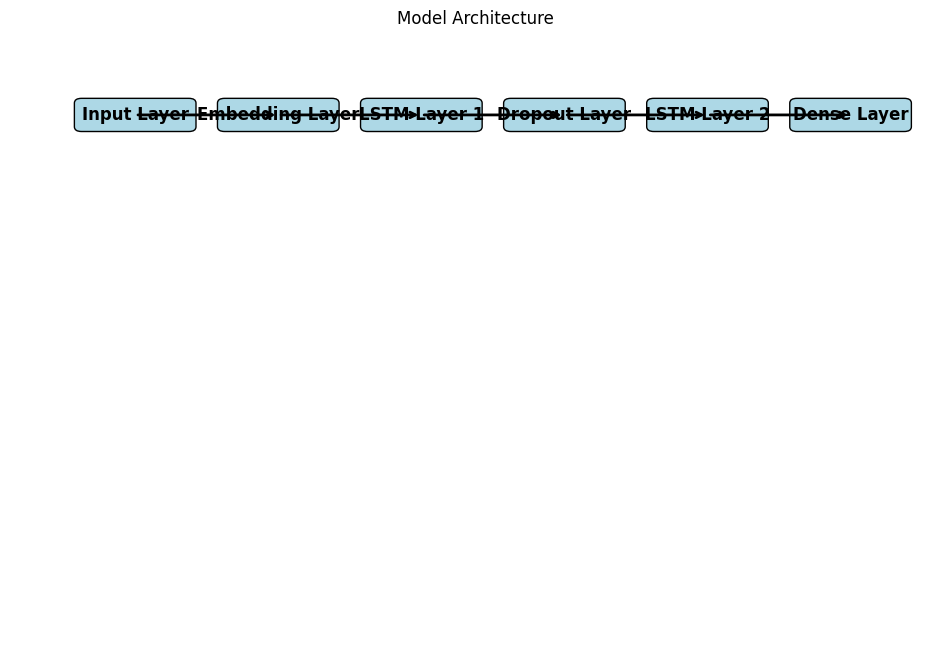

In [48]:
# plot_model(model, to_file='model_glove_lstm.png', show_shapes=True, show_layer_names=True)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_model_architecture(model, file_path='model_glove_lstm.png'):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define a simple model architecture (customize as needed)
    layers = [
        ("Input Layer", 0, 5),
        ("Embedding Layer", 1, 5),
        ("LSTM Layer 1", 2, 5),
        ("Dropout Layer", 3, 5),
        ("LSTM Layer 2", 4, 5),
        ("Dense Layer", 5, 5),
    ]
    
    # Plot the layers
    for layer_name, x, y in layers:
        rect = patches.FancyBboxPatch((x*2, y*2), 1.5, 0.5, boxstyle="round,pad=0.1", edgecolor='black', facecolor='lightblue')
        ax.add_patch(rect)
        ax.text(x*2 + 0.75, y*2 + 0.25, layer_name, ha='center', va='center', fontsize=12, weight='bold')
    
    # Draw arrows between layers
    for i in range(len(layers) - 1):
        x1, y1 = layers[i][1]*2 + 0.75, layers[i][2]*2 + 0.25
        x2, y2 = layers[i+1][1]*2 + 0.75, layers[i+1][2]*2 + 0.25
        ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle="->", color='black', lw=2))
    
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)
    ax.axis('off')
    plt.title('Model Architecture')
    plt.savefig(file_path, dpi=300)
    plt.show()

# Assuming 'model' is your Keras model
plot_model_architecture(model)


In [49]:
# padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
# padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

# padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
# padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

# labels = to_categorical(data.loc[:,'stance_cat'])

# labels_train = labels[:int(len(labels)*0.9),:]
# labels_test = labels[int(len(labels)*0.9):,:]


import pandas as pd
from keras.utils import to_categorical

# Load your data
data = pd.read_csv(os.path.join(os.getcwd(), 'data_combined_subset.csv'))

# Check column names
print(data.columns)

# Ensure 'stance_cat' column exists
if 'stance_cat' not in data.columns:
    data['stance_cat'] = data['Stance'].map({'agree':0, 'disagree':1, 'discuss':2, 'unrelated':3}).astype(int)

# Check if column was created correctly
print(data.head())

# Proceed with your code if 'stance_cat' column is present
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

labels = to_categorical(data['stance_cat'])

labels_train = labels[:int(len(labels)*0.9),:]
labels_test = labels[int(len(labels)*0.9):,:]


Index(['Headline', 'Body ID', 'Stance', 'articleBody'], dtype='object')
                                            Headline  Body ID     Stance  \
0  Report: Amazon to Launch Ad-Supported Streamin...     1071  unrelated   
1  That Boko Haram Ceasefire in Nigeria Isn’t A C...       35  unrelated   
2  High School Student Rumored to Have Made $72 M...     1024  unrelated   
3  Al-Shabaab co-founder confirmed killed by US a...      646  unrelated   
4  Confusion swirls, details murky in arrest of I...     2337    discuss   

                                         articleBody  stance_cat  
0                                                NaN           3  
1                                                NaN           3  
2  A 10-year-old member of the ISIS terror group ...           3  
3  The mystery surrounding the disappearance of 4...           3  
4                                                NaN           2  


## Creating Checkpoints

For saving the latest model trained after every epoch

In [50]:
# MODELS_DIR = os.path.join("/home/abhinav/fake_news_challenge/model/glove_lstm")
filepath = os.path.join(os.getcwd(),"{epoch:02d}-{val_accuracy:.2f}.hdf5.keras")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Model Training

In [51]:
model_history = model.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test),
                                          callbacks=[checkpoint])

Epoch 1/40
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7205 - loss: 0.8759
Epoch 1: val_accuracy improved from -inf to 0.72400, saving model to g:\PROJECTS\MINI_PROJECT\Github\01-0.72.hdf5.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.7205 - loss: 0.8756 - val_accuracy: 0.7240 - val_loss: 0.8117
Epoch 2/40
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7282 - loss: 0.7987
Epoch 2: val_accuracy improved from 0.72400 to 0.72960, saving model to g:\PROJECTS\MINI_PROJECT\Github\02-0.73.hdf5.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7282 - loss: 0.7987 - val_accuracy: 0.7296 - val_loss: 0.7999
Epoch 3/40
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7343 - loss: 0.7851
Epoch 3: val_accuracy improved from 0.72960 to 0.73360, saving model to g:\PROJECTS\MINI_PROJECT\Github\03-0.73.hdf5.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.7343 - loss: 0.7851 - val_accuracy: 0.7336 - val_loss: 0.7887
Epoch 4/40
352/3

## Model Training History

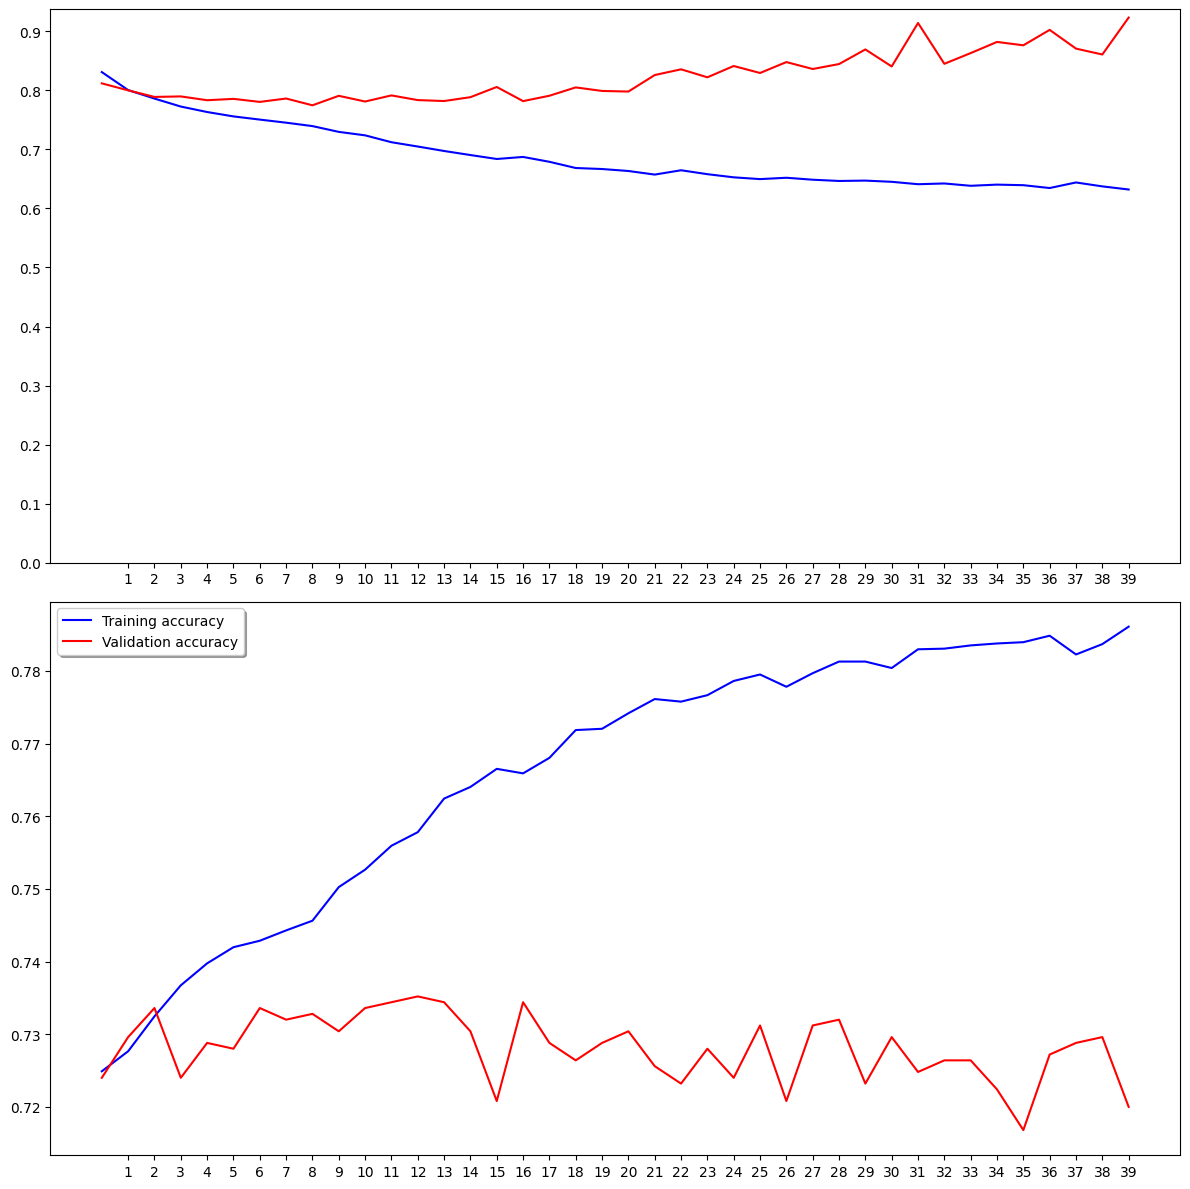

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 40, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 40, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()